# ***Tech Challenge - Fase 2***

## **Grupo 38**


Leadnro Braga Alves

Rodrigo Mitsuo Yoshida

Roberto Yukio Ihara

## O Problema

Imagine que você foi escalado para um time de investimentos e precisará realizar um modelo preditivo com dados da IBOVESPA (Bolsa de valores) para criar uma série temporal e prever diariamente o fechamento da base. Para isso utilize a base de dados contida no site da investing e selecione o período “diário”, com o intervalo de tempo que achar adequado. Você precisará demonstrar para o time de investimentos:
- O modelo com o storytelling, desde a captura do dado até a entrega do modelo;
- Justificar a técnica utilizada;
- Atingir uma acuracidade adequada (acima de 70%).

## Análise Exploratória dos Dados

Bibliotecas

In [493]:
import pandas as pd
import numpy as np 
import warnings
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.stattools import acf, pacf
from dateutil.relativedelta import relativedelta
import streamlit as st

from statsforecast import StatsForecast
from statsforecast.models import Naive, AutoARIMA
#from statsmodels.tsa.arima.model import ARIMA
#from pmdarima.arima import auto_arima
#from sklearn.metrics import mean_squared_error,mean_absolute_error
#from math import sqrt

from datetime import date

from statsmodels.tsa.stattools import adfuller

#from fbprophet import Prophet
from prophet import Prophet
#from prophet.plot import plot_plotly, plot_components_plotly

warnings.filterwarnings("ignore")

Vamos utilizar o yfinance que é uma biblioteca do Python que permite a extração e análise de dados financeiros do Yahoo Finance.

In [494]:

today = date.today()

ticker = '^BVSP'
inicio = '1900-01-01'
fim = today
window = 12
#pega um mês antes da data passada para preencher o primeiros dias do ano.
#inicio_anterior = pd.to_datetime(inicio)
#inicio_anterior = inicio_anterior - relativedelta(months=1)


#carrega informacoes do IBovespa
#df = yf.download(ticker, start=inicio_anterior, end=fim)
df = yf.download(ticker, start=inicio, end=fim)

#seleciona somente a coluna de fechamento
df_close = df[['Close']]

df_close.head()

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
1993-04-27,24.500000
1993-04-28,24.299999
1993-04-29,23.700001
1993-04-30,24.100000
1993-05-03,24.100000


Como o Ibovespa possui somente cotação dos dias úteis vamos preencher os dias faltantes com a última cotação conhecida.

In [495]:
#Criar datas faltantes repetindo o valor ultima data conhecida
df_close_last = df_close
df_close_last = df_close_last.resample('D').ffill()
df_close_last = df_close_last[df_close_last.index >= inicio]


'''
#Cria coluna ID e coloca a coluna como indice
df_close_resample = df_close_last.copy()

df_close_resample['id'] = range(1, len(df_close_resample) + 1)
df_close_resample.reset_index(inplace=True)
df_close_resample = df_close_resample.set_index('id')

df_close_resample['Date'] = pd.to_datetime(df_close_resample['Date'], format='%Y-%m-%d')

#renomear colunas do dataframe
df_close_resample.columns = ['ds', 'y']
df_close_resample['unique_id'] = 'IBOV'


df_close_resample.head(20)
'''

"\n#Cria coluna ID e coloca a coluna como indice\ndf_close_resample = df_close_last.copy()\n\ndf_close_resample['id'] = range(1, len(df_close_resample) + 1)\ndf_close_resample.reset_index(inplace=True)\ndf_close_resample = df_close_resample.set_index('id')\n\ndf_close_resample['Date'] = pd.to_datetime(df_close_resample['Date'], format='%Y-%m-%d')\n\n#renomear colunas do dataframe\ndf_close_resample.columns = ['ds', 'y']\ndf_close_resample['unique_id'] = 'IBOV'\n\n\ndf_close_resample.head(20)\n"

## Verificando se a série é estacionária

Plotando o gráfio Data x Valor

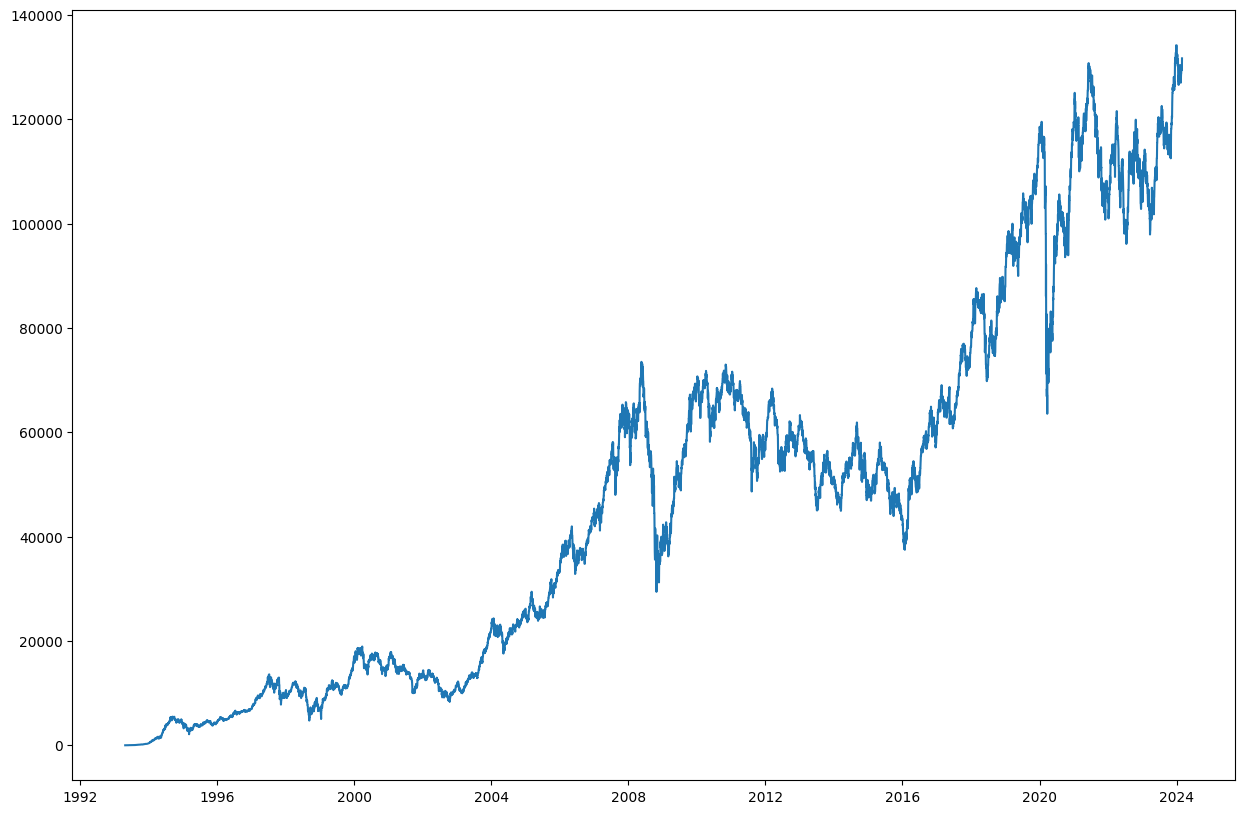

In [496]:
plt.figure(figsize=(15, 10))
plt.plot(df_close_last.index, df_close_last.Close)

Decomposição

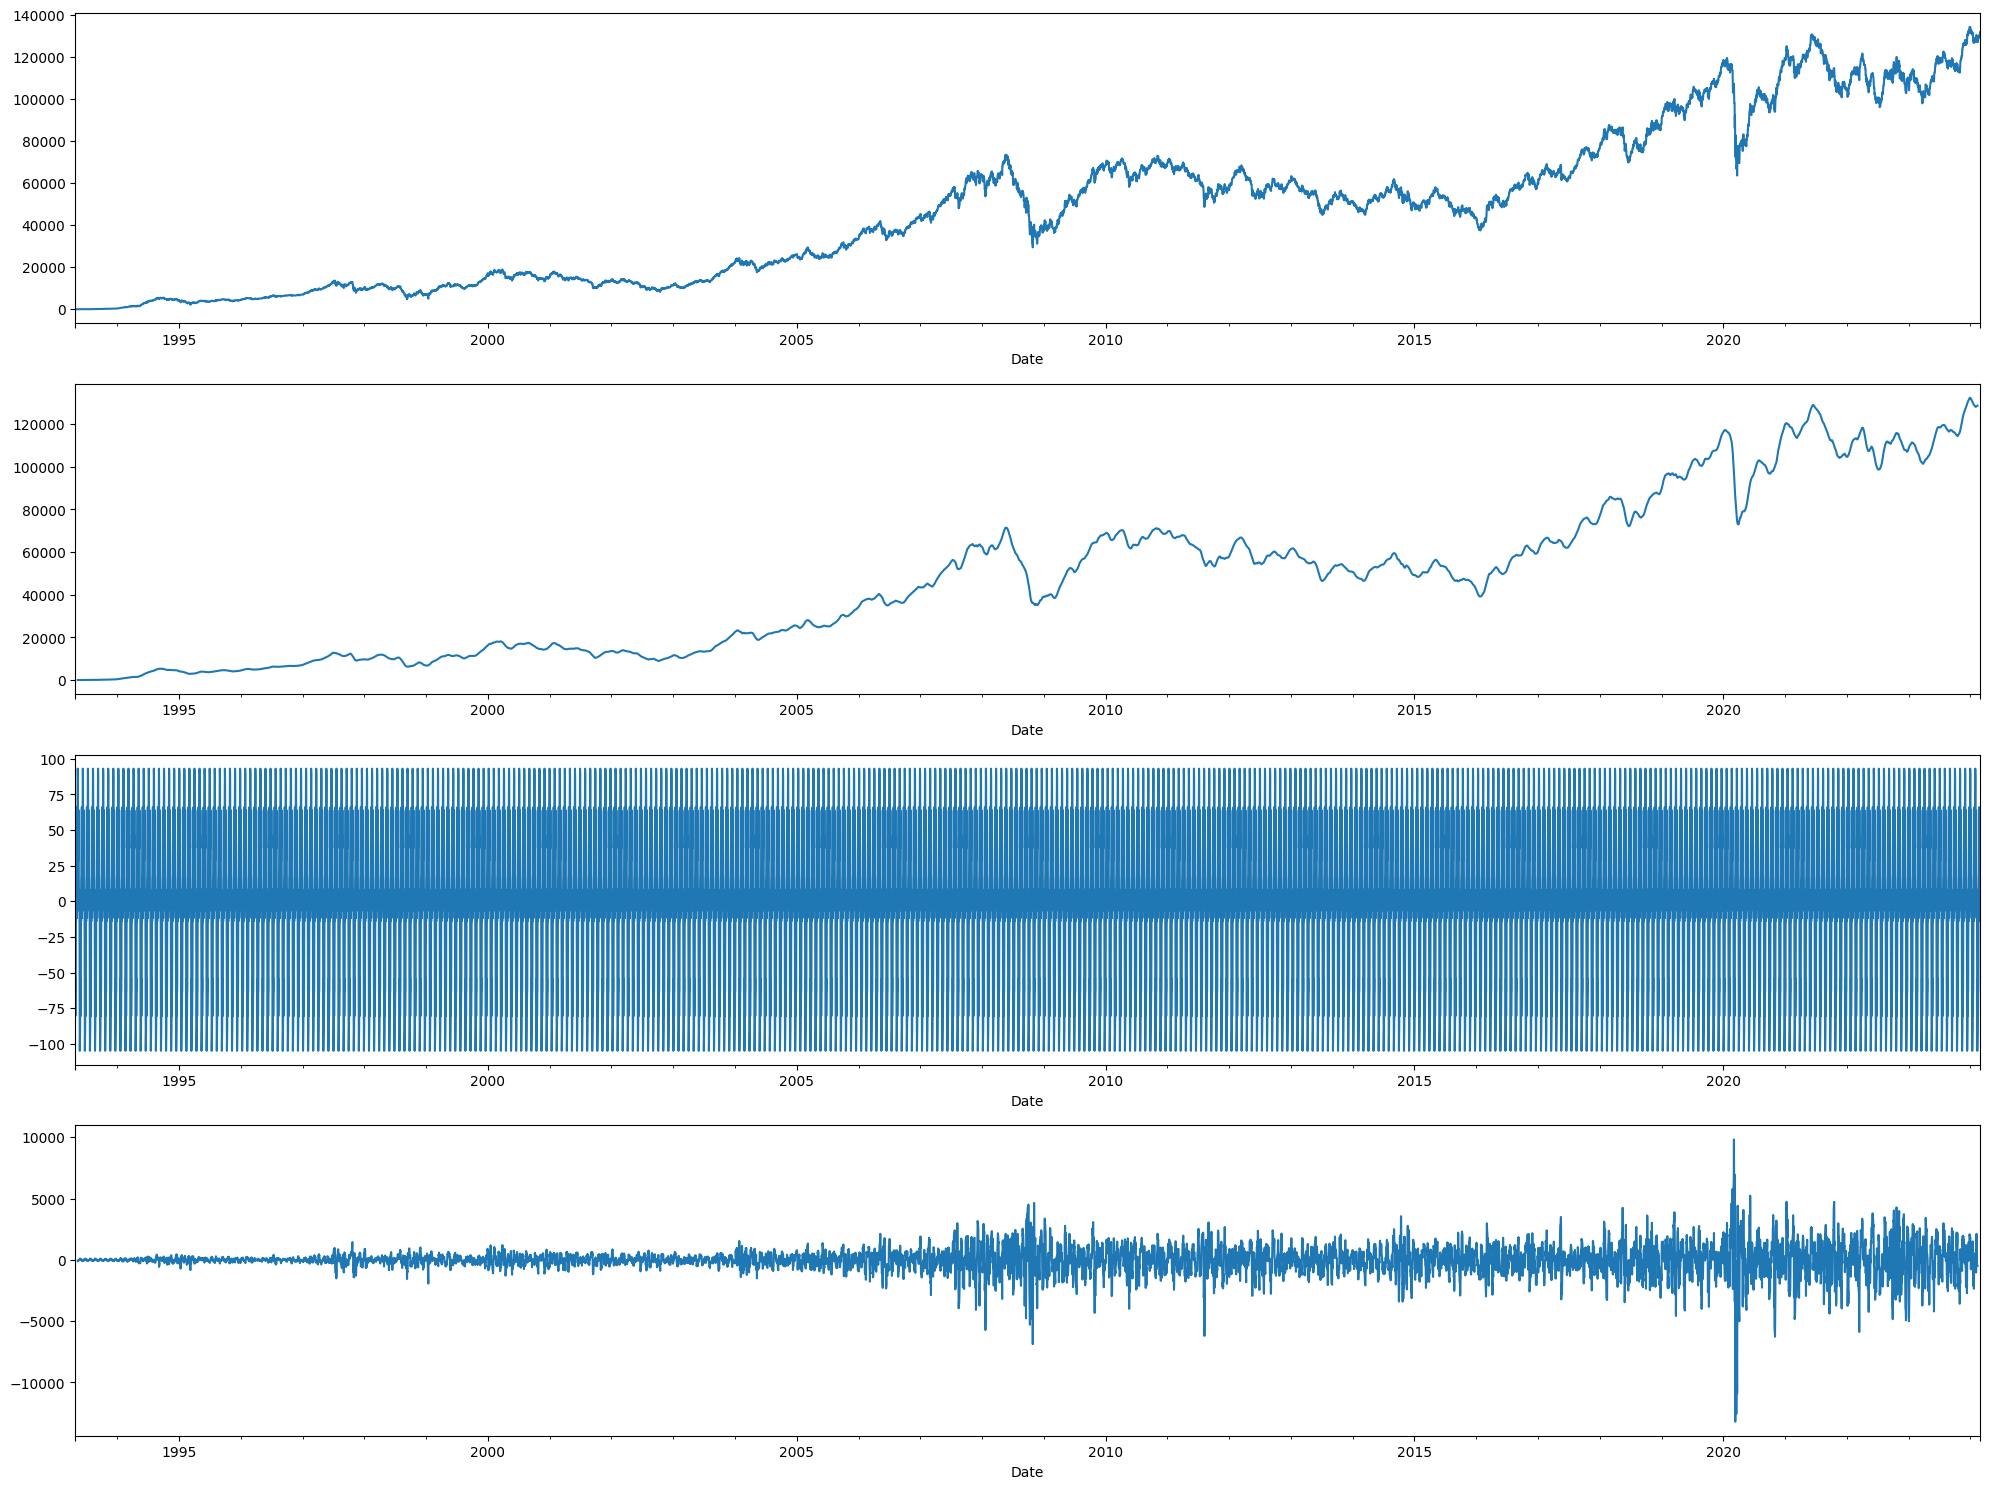

In [497]:
#Decomposicao
decomposition = seasonal_decompose(df_close_last , model='additive', period=30)

# Plota o resultado da decomposição
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(20,15))
decomposition.observed.plot(ax=ax1)
decomposition.trend.plot(ax=ax2)
decomposition.seasonal.plot(ax=ax3)
decomposition.resid.plot(ax=ax4)
plt.tight_layout()

# Usa st.pyplot() para renderizar a figura no Streamlit
#st.pyplot(fig)


Plotagem de Rolling Statistics

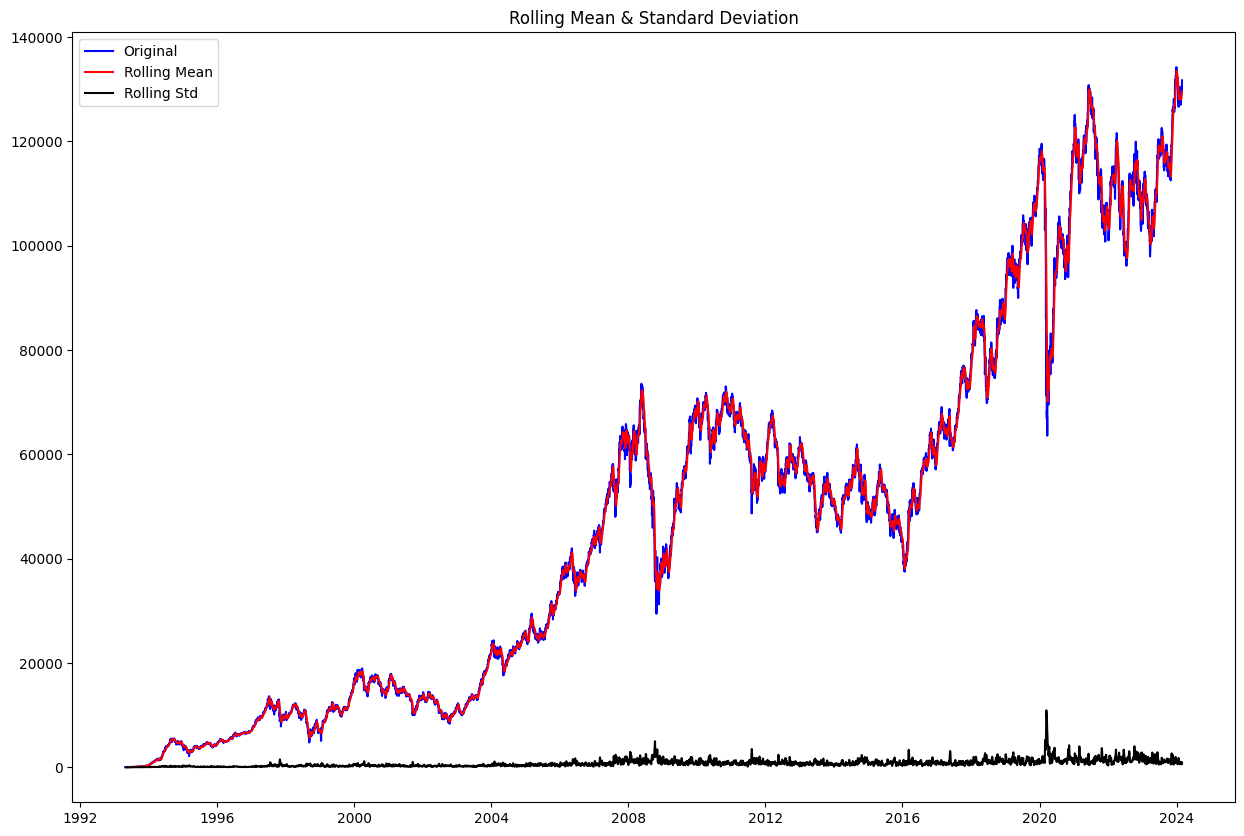

In [498]:
#Rolling statistics - Técnica Visual
rolmean = df_close_last.rolling(window=window).mean().dropna()
rolstd = df_close_last.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(df_close_last, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Embora a variação de desvio padrão seja pequena, a média está claramente aumentando com o tempo e isto não é uma característica de série estacionária. Além disso, a estatística de teste é muito mais do que os valores críticos. Note que os valores assinalados devem ser comparados e não os valores absolutos.

Dickey-Fuller teste

In [499]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_close_last, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                    -0.293668
p-value                            0.926396
#Lags Used                        15.000000
Number of Observations Used    11248.000000
Critical Value (1%)               -3.430932
Critical Value (5%)               -2.861797
Critical Value (10%)              -2.566907
dtype: float64


O teste de Dickey-Fuller é uma técnica estatística comumente usada para determinar se uma série temporal é estacionária ou não.

Estatística do teste: O valor da estatística do teste é -0.642799. Para que a série seja considerada estacionária, o valor da estatística do teste deve ser menor que os valores críticos.

Valor-p: O valor-p é 0.861015. Geralmente, se o valor-p é menor que 0.05, rejeitamos a hipótese nula e a série é considerada estacionária. Neste caso, o valor-p é significativamente maior que 0.05, indicando que a série não é estacionária.

Valores críticos: Os valores críticos para os níveis de significância de 1%, 5% e 10% são -3.431095, -2.861869 e -2.566945, respectivamente. A estatística do teste é maior que todos esses valores, o que reforça que a série não é estacionária.

Portanto, com base nesses resultados, a série temporal analisada não é estacionária. Você pode considerar diferenciar a série para torná-la estacionária e, em seguida, aplicar modelos de previsão adequados para séries temporais estacionárias.

## Transformar em estacionária

Uma das primeiras manobras para reduzir a tendência pode ser transformação. Por exemplo, neste caso, podemos ver claramente que existe uma tendência positiva significativa. Assim, podemos aplicar transformação que penaliza os valores maiores mais do que valores menores. 

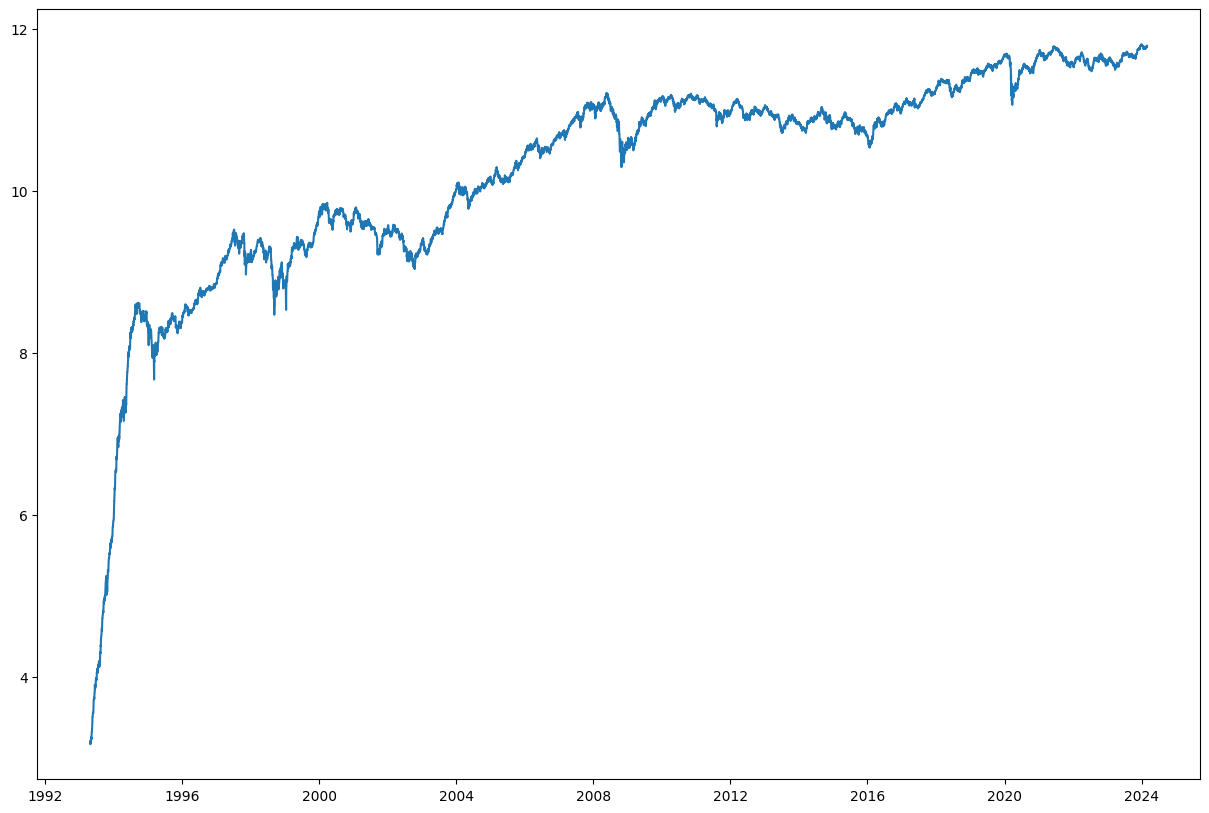

In [500]:
ts_log = np.log(df_close_last)
plt.figure(figsize=(15,10))
plt.plot(ts_log)

Média Móvel

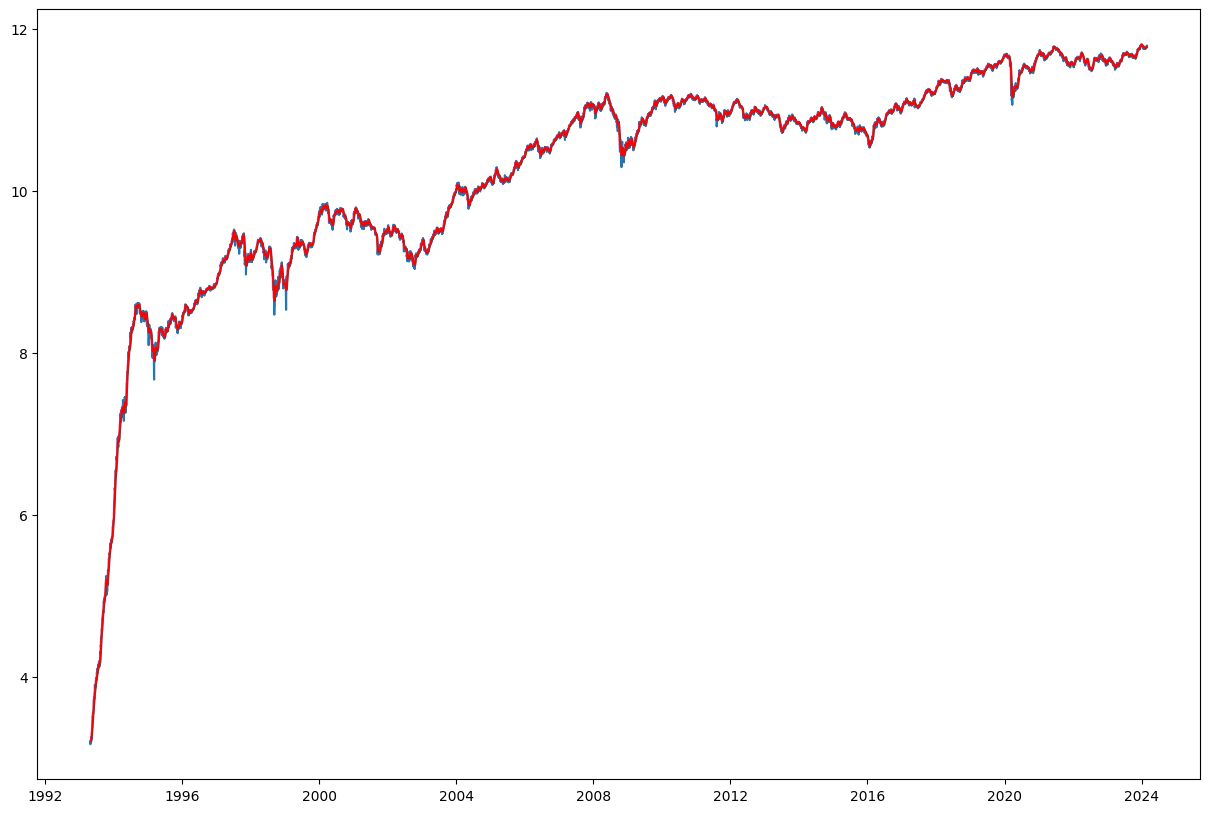

In [501]:
moving_avg = ts_log.rolling(window=window).mean()
plt.figure(figsize=(15,10))
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

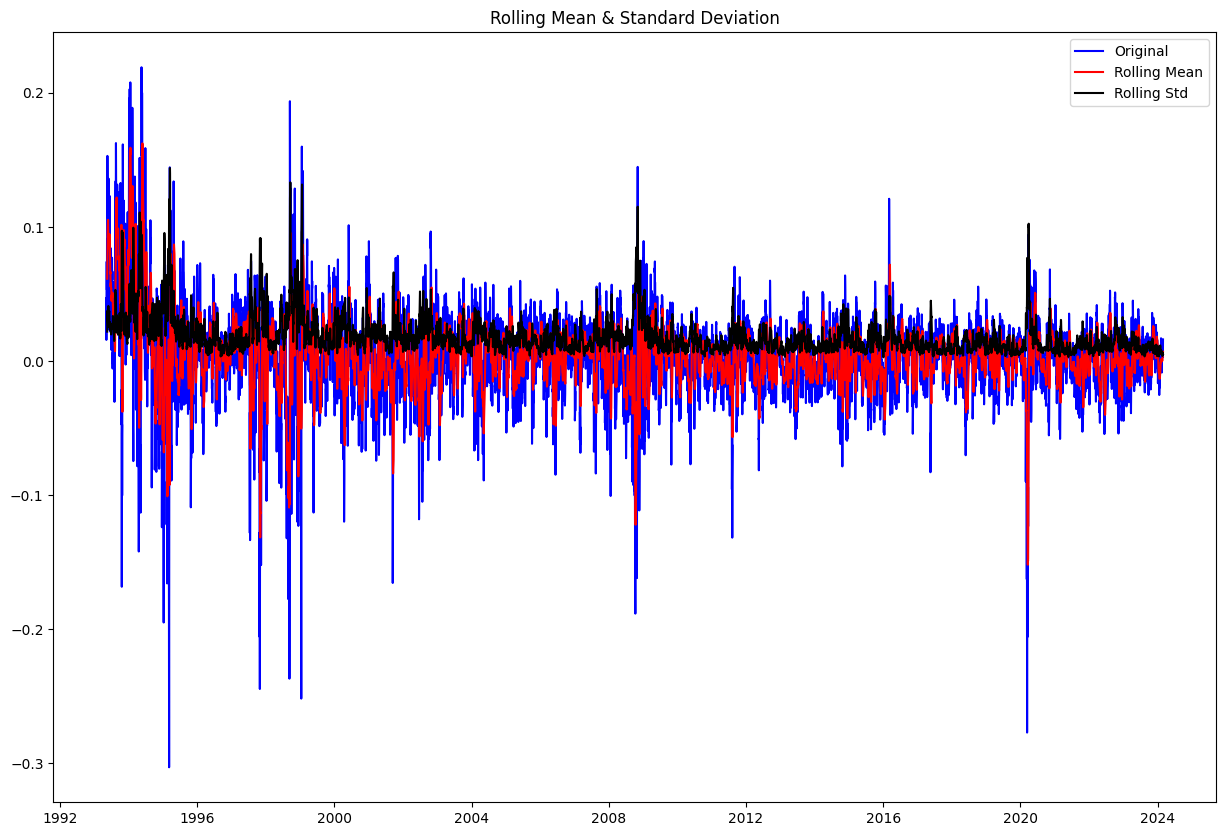

In [502]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

#Rolling statistics
rolmean = ts_log_moving_avg_diff.rolling(window=window).mean().dropna()
rolstd = ts_log_moving_avg_diff.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(ts_log_moving_avg_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [503]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(ts_log_moving_avg_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -1.219372e+01
p-value                        1.268550e-22
#Lags Used                     3.600000e+01
Number of Observations Used    1.121600e+04
Critical Value (1%)           -3.430933e+00
Critical Value (5%)           -2.861798e+00
Critical Value (10%)          -2.566907e+00
dtype: float64


Estatística do teste: O valor da estatística do teste é -3.062207. Para que a série seja considerada estacionária, o valor da estatística do teste deve ser menor que os valores críticos.

Valor-p: O valor-p é 0.029479. Geralmente, se o valor-p é menor que 0.05, rejeitamos a hipótese nula e a série é considerada estacionária. Neste caso, o valor-p é menor que 0.05, indicando que a série é estacionária.

Valores críticos: Os valores críticos para os níveis de significância de 1%, 5% e 10% são -3.434761, -2.863488 e -2.567807, respectivamente. A estatística do teste é maior que o valor crítico de 1%, mas menor que os valores críticos de 5% e 10%, o que indica que a série é estacionária a um nível de significância de 5% e 10%.

Portanto, com base nesses resultados, a série temporal analisada é estacionária a um nível de significância de 5% e 10%. Isso significa que a série não possui uma tendência ou sazonalidade sistemática.

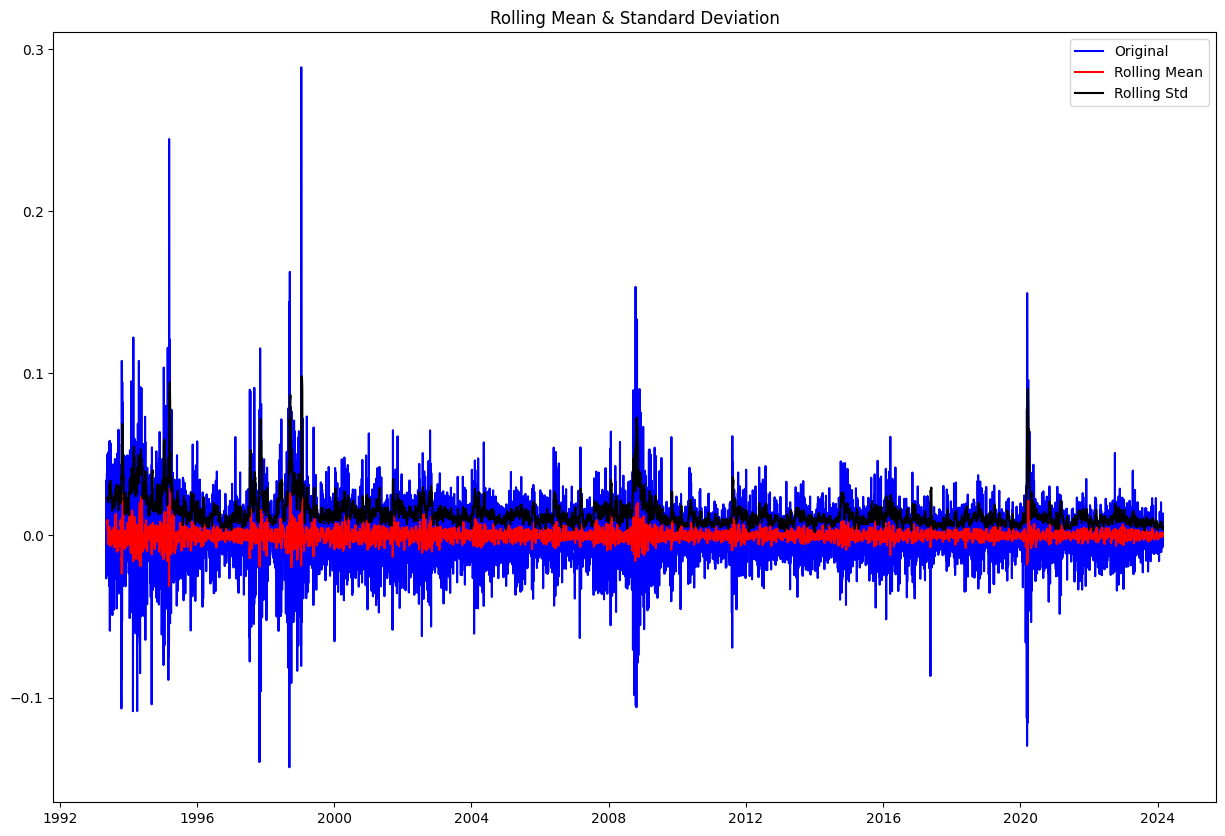

In [504]:
#Deixar mais estacionária - Derivada
df_diff = ts_log_moving_avg_diff.diff(1)

df_diff.dropna(inplace=True)

#Rolling statistics
rolmean = df_diff.rolling(window=window).mean().dropna()
rolstd = df_diff.rolling(window=window).std().dropna()

#Plot rolling statistics:
plt.figure(figsize=(15,10))
orig = plt.plot(df_diff, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [505]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df_diff, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   -25.911414
p-value                            0.000000
#Lags Used                        40.000000
Number of Observations Used    11211.000000
Critical Value (1%)               -3.430933
Critical Value (5%)               -2.861798
Critical Value (10%)              -2.566907
dtype: float64


Estatística do teste: O valor da estatística do teste é -9.195744. Para que a série seja considerada estacionária, o valor da estatística do teste deve ser menor que os valores críticos.

Valor-p: O valor-p é 2.065080e-15. Geralmente, se o valor-p é menor que 0.05, rejeitamos a hipótese nula e a série é considerada estacionária. Neste caso, o valor-p é significativamente menor que 0.05, indicando que a série é estacionária.

Valores críticos: Os valores críticos para os níveis de significância de 1%, 5% e 10% são -3.434761, -2.863488 e -2.567807, respectivamente. A estatística do teste é menor que todos esses valores, o que indica que a série é estacionária a todos esses níveis de significância.

Portanto, com base nesses resultados, a série temporal analisada é estacionária. Isso significa que a série não possui uma tendência ou sazonalidade sistemática.

## Modelos

In [506]:
def wmape(y_true, y_pred):
  #return np.abs(y_true-y_pred).sum() / np.abs(y_true).sum()
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))


In [507]:
#renomear o campo date para ds, campo close para y e criar o campo unique_id
df_fechamento_n_estacionaria = df_close_last.copy()
df_fechamento_n_estacionaria['id'] = range(1, len(df_fechamento_n_estacionaria) + 1)
df_fechamento_n_estacionaria.reset_index(inplace=True)
df_fechamento_n_estacionaria = df_fechamento_n_estacionaria.set_index('id')
df_fechamento_n_estacionaria['Date'] = pd.to_datetime(df_fechamento_n_estacionaria['Date'], format='%Y-%m-%d')
df_fechamento_n_estacionaria.columns = ['ds', 'y']
df_fechamento_n_estacionaria['unique_id'] = 'IBOV'

df_modelo_prophet = df_fechamento_n_estacionaria.copy()


In [508]:
#renomear o campo date para ds, campo close para y e criar o campo unique_id
df_fechamento_estacionaria = df_diff.copy()
df_fechamento_estacionaria['id'] = range(1, len(df_fechamento_estacionaria) + 1)
df_fechamento_estacionaria.reset_index(inplace=True)
df_fechamento_estacionaria = df_fechamento_estacionaria.set_index('id')
df_fechamento_estacionaria.columns = ['ds', 'y']
df_fechamento_estacionaria['unique_id'] = 'IBOV'

df_modelo = df_fechamento_estacionaria.copy()

In [509]:
treino_dias = 365
teste_dias = 3

In [510]:
# Dividindo os dados em treino e teste
'''
treino = df_modelo[(df_modelo['ds'] >= '2023-01-01') & (df_modelo['ds'] < '2024-01-01')]
teste = df_modelo[(df_modelo['ds'] >= '2024-01-01') & (df_modelo['ds'] <= '2024-01-10')]
h = len(teste.index)
'''

treino = df_modelo[-(treino_dias + teste_dias):-teste_dias]
teste = df_modelo[-teste_dias:]
h = len(teste.index)


In [511]:
'''
treino_prophet = df_modelo_prophet[(df_modelo_prophet['ds'] >= '2015-01-01') & (df_modelo_prophet['ds'] < '2024-01-01')]
teste_prophet = df_modelo_prophet[(df_modelo_prophet['ds'] >= '2024-01-01') & (df_modelo_prophet['ds'] <= '2024-01-10')]
h_prophet = len(teste_prophet.index)
'''

treino_prophet = df_modelo_prophet[-(treino_dias + teste_dias):-teste_dias]
teste_prophet = df_modelo_prophet[-teste_dias:]
h_prophet = len(teste_prophet.index)


In [512]:
min_date = treino['ds'].min()
max_date = treino['ds'].max()

print('Menor data:', min_date)
print('Maior data:', max_date)

Menor data: 2023-02-25 00:00:00
Maior data: 2024-02-24 00:00:00


Modelo Base Navi

WMAPE: 103.23%


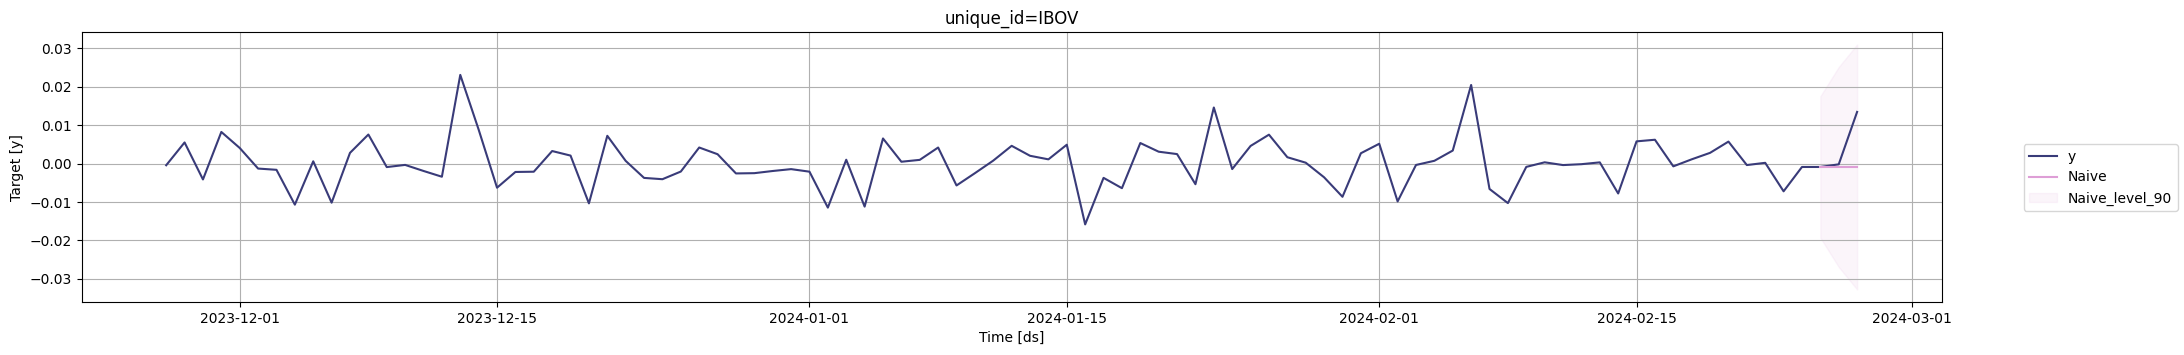

In [513]:
model1 = StatsForecast(models=[Naive()], freq='D', n_jobs=-1)
model1.fit(treino)

forecast_df1 = model1.predict(h=h, level=[90])
forecast_df1 = forecast_df1.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')

wmape1 = wmape(forecast_df1['y'].values, forecast_df1['Naive'].values)
print(f"WMAPE: {wmape1:.2%}")

model1.plot(treino, forecast_df1, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

In [514]:
df_joined = forecast_df1[['ds', 'y']].merge(forecast_df1[['ds', 'Naive']], on='ds')

print(df_joined)

          ds         y     Naive
0 2024-02-25 -0.000902 -0.000902
1 2024-02-26 -0.000216 -0.000902
2 2024-02-27  0.013425 -0.000902


AutoARIMA

WMAPE: 104.33%


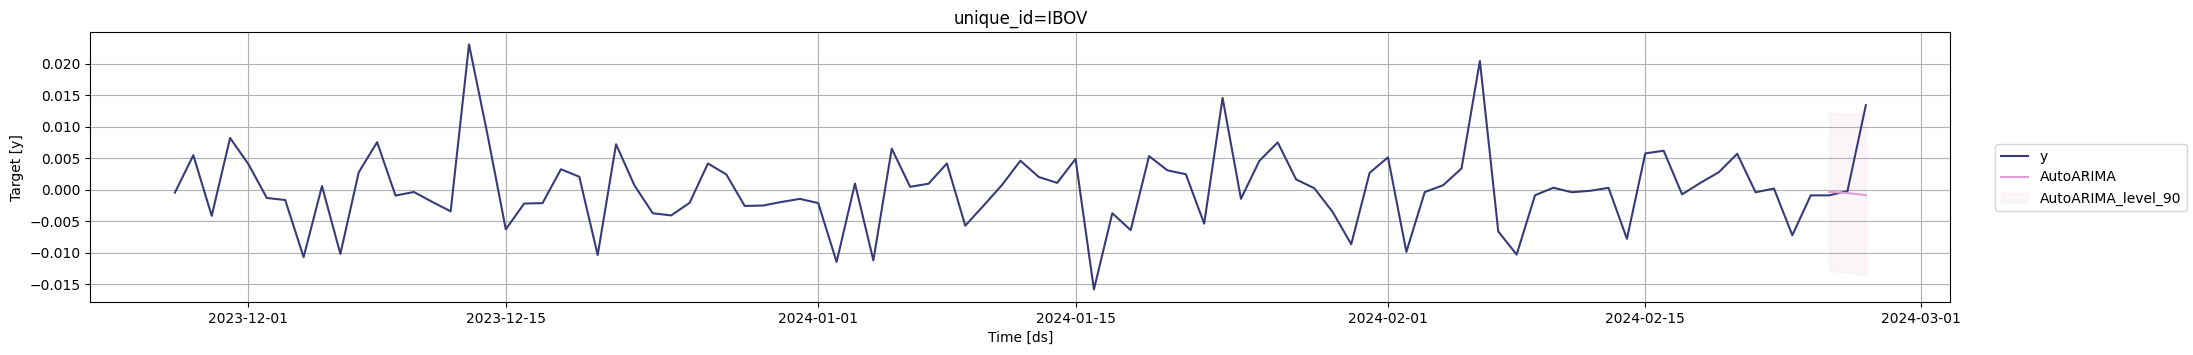

In [515]:
model2 = StatsForecast(models=[AutoARIMA(season_length=7)], freq='D', n_jobs=-1)
model2.fit(treino)

forecast_df2 = model2.predict(h=h, level=[90])
forecast_df2 = forecast_df2.reset_index().merge(teste, on=['ds', 'unique_id'], how='left')

wmape2 = wmape(forecast_df2['y'].values, forecast_df2['AutoARIMA'].values)
print(f"WMAPE: {wmape2:.2%}")

model2.plot(treino, forecast_df2, level=[90], unique_ids=['IBOV'],engine ='matplotlib', max_insample_length=90)

In [516]:
forecast_df2

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,y
0,IBOV,2024-02-25,-0.000345,-0.012898,0.012209,-0.000902
1,IBOV,2024-02-26,-0.000531,-0.013167,0.012105,-0.000216
2,IBOV,2024-02-27,-0.000875,-0.013575,0.011825,0.013425


In [517]:
df_joined = forecast_df2[['ds', 'y']].merge(forecast_df2[['ds', 'AutoARIMA']], on='ds')

print(df_joined)

          ds         y  AutoARIMA
0 2024-02-25 -0.000902  -0.000345
1 2024-02-26 -0.000216  -0.000531
2 2024-02-27  0.013425  -0.000875


Prophet

14:25:07 - cmdstanpy - INFO - Chain [1] start processing
14:25:07 - cmdstanpy - INFO - Chain [1] done processing


WMAPE: 1.61%


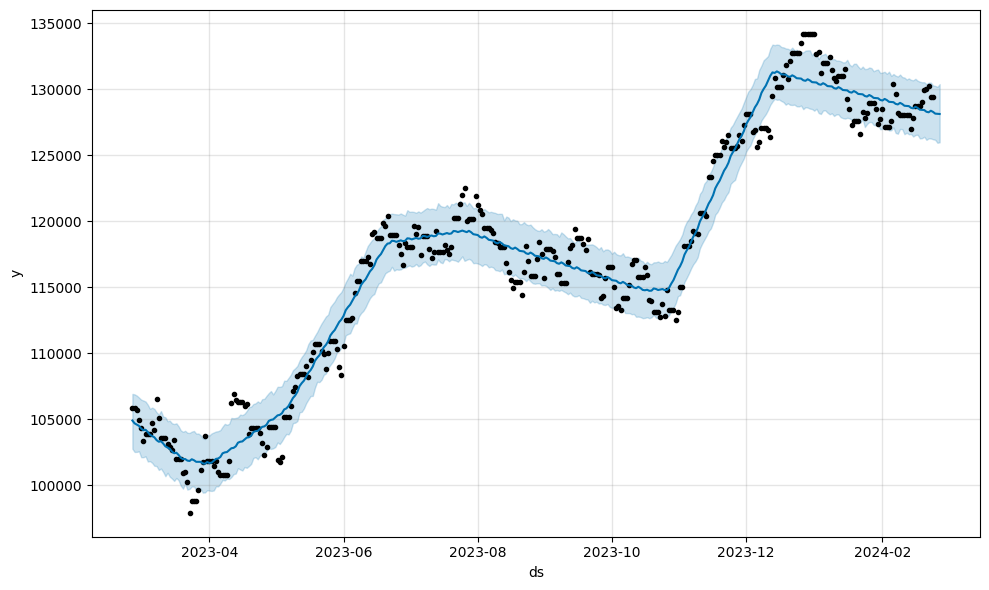

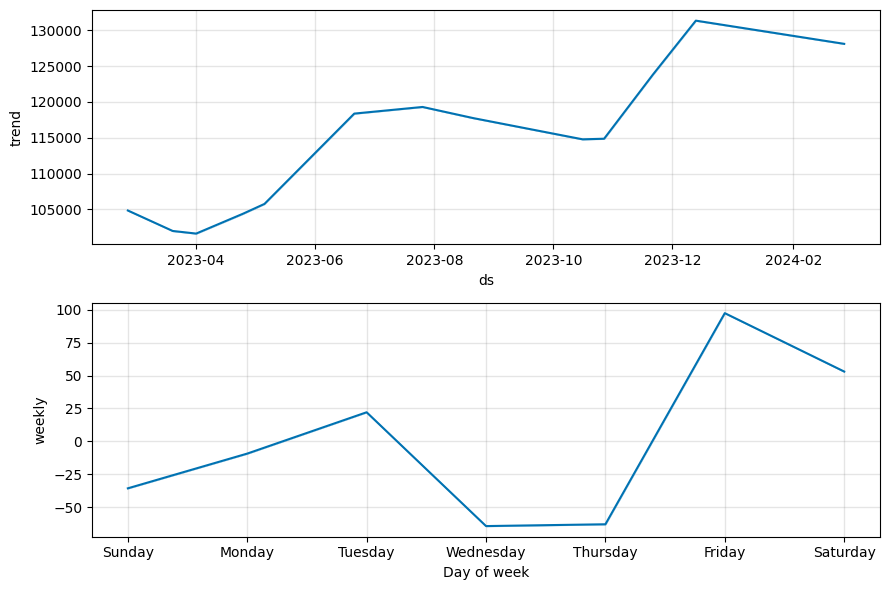

In [518]:
model3 = Prophet()
model3.fit(treino_prophet)


future = model3.make_future_dataframe(periods=h_prophet)
#future.tail()

forecast3 = model3.predict(future)
#forecast3[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


# fazendo previsões com os dados de teste
test_forecast = model3.predict(teste_prophet)
# olhando os resultados das previsões com os dados de teste
#test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

forecast_df = test_forecast.reset_index().merge(teste_prophet, on=['ds'], how='left')


wmape3 = wmape(forecast_df['y'], forecast_df['yhat'])
print(f"WMAPE: {wmape3:.2%}")

fig1 = model3.plot(forecast3)

fig2 = model3.plot_components(forecast3)




In [519]:
forecast_df

,index,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
0,0,2024-02-25,128194.072911,125980.381684,130230.860061,128194.072911,128194.072911,-35.774761,-35.774761,-35.774761,-35.774761,-35.774761,-35.774761,0.0,0.0,0.0,128158.298150,129419.0,IBOV
1,1,2024-02-26,128151.487881,126091.454263,130441.653268,128151.487881,128151.487881,-9.342538,-9.342538,-9.342538,-9.342538,-9.342538,-9.342538,0.0,0.0,0.0,128142.145343,129609.0,IBOV
2,2,2024-02-27,128108.902850,125914.489443,130260.031221,128108.902850,128108.902850,22.104158,22.104158,22.104158,22.104158,22.104158,22.104158,0.0,0.0,0.0,128131.007009,131689.0,IBOV


<Axes: xlabel='ds', ylabel='y'>

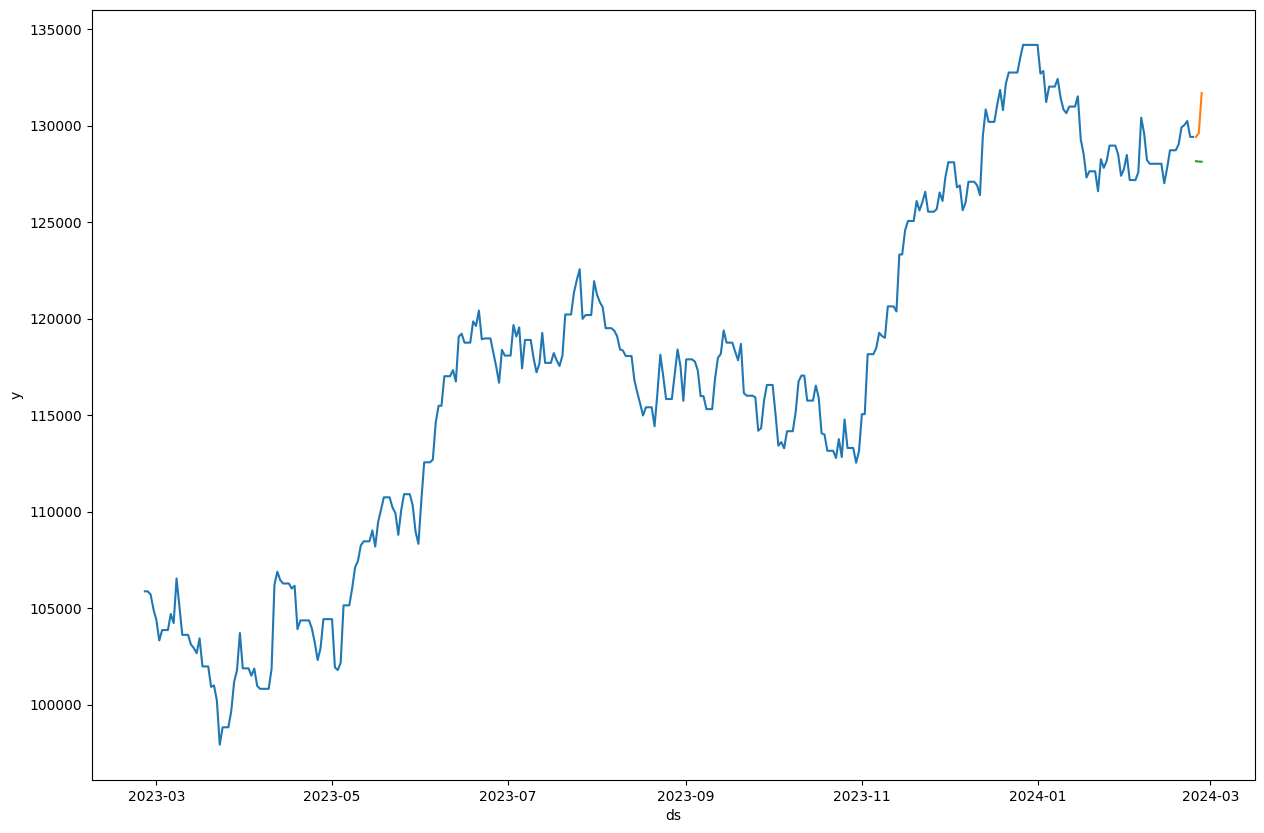

In [520]:
plt.figure(figsize=(15, 10))

sns.lineplot(
    data = treino_prophet,
    x='ds',
    y='y'
)
sns.lineplot(
    data = forecast_df,
    x='ds',
    y='y'
)
sns.lineplot(
    data = forecast_df,
    x='ds',
    y='yhat'
)

In [531]:
a = forecast_df[['ds', 'y', 'yhat']]
a

,ds,y,yhat
0,2024-02-25,129419.0,128158.298150
1,2024-02-26,129609.0,128142.145343
2,2024-02-27,131689.0,128131.007009
